In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import xmltodict
import random
from os import listdir
from os.path import isfile, join
import torchvision 
import torch 
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Extract each image related to its related label

In [6]:
#extract name of the images:
def getImageNames():
    image_names = []
    for dirname, _, filenames in os.walk('kaggle/input'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension != '.xml':
                image_names.append(filename)
    return image_names

#extract image path and label path:
def get_path(image_name):
    
    #CREDIT: kaggle.com/dohunkim
    
    home_path = 'kaggle/input/medical_mask_dataset_bundle_archive/'
    image_path = home_path + 'images/' + image_name
    
    if image_name[-4:] == 'jpeg':
        label_name = image_name[:-5] + '.xml'
    else:
        label_name = image_name[:-4] + '.xml'
    
    label_path = home_path + 'labels/' + label_name
        
    return  image_path, label_path


# Plot some of the images with their related annotation:

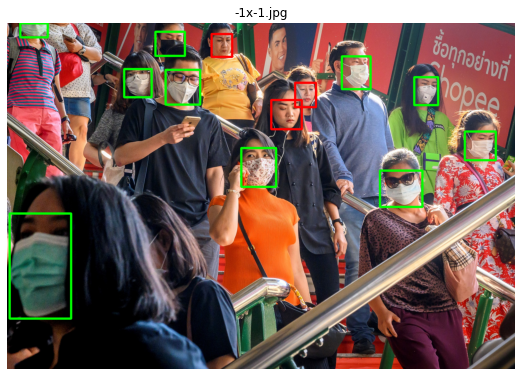

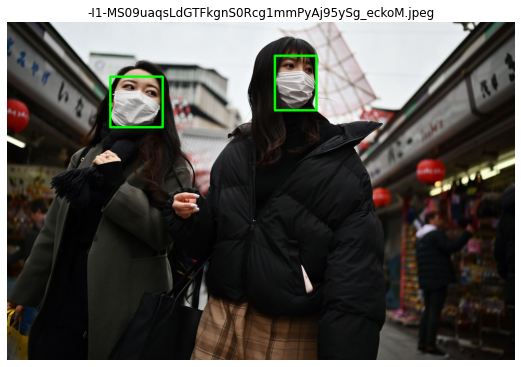

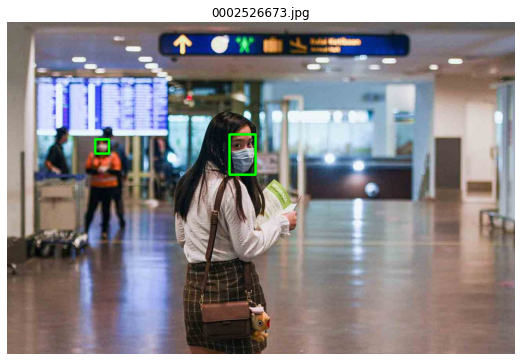

In [10]:
def parse_xml(label_path):
    
    #CREDIT: kaggle.com/dohunkim
    
    x = xmltodict.parse(open(label_path , 'rb'))
    item_list = x['annotation']['object']
    
    # when image has only one bounding box
    if not isinstance(item_list, list):
        item_list = [item_list]
        
    result = []
    
    for item in item_list:
        name = item['name']
        bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                  (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
        result.append((name, bndbox))
    
    size = [int(x['annotation']['size']['width']), 
            int(x['annotation']['size']['height'])]
    
    return result, size


def visualize_image(image_name, bndbox=True):
    
    #CREDIT: kaggle.com/dohunkim
    
    
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if bndbox:
        labels, size = parse_xml(label_path)
        thickness = int(sum(size)/400.)
        
        for label in labels:
            name, bndbox = label
            
            if name == 'good':
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'bad':
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            else: # name == 'none'
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(image_name)
    plt.imshow(image)
    plt.show()
    
image_names = getImageNames()

NUM_OF_IMGS_TO_VISUALIZE = 3

for i in range(NUM_OF_IMGS_TO_VISUALIZE):
    visualize_image(image_names[i])

# Crop to just select the interesting locations for training

In [12]:
def cropImage(image_name):
    image_path, label_path = get_path(image_name)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    labels, size = parse_xml(label_path)
    
    cropedImgLabels = []

    for label in labels:
        name, bndbox = label
        
        
        croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
        
        label_num = 0
        
        if name == "good":
            label_num = 0
        elif name == "bad":
            label_num = 1
        else:
            label_num = 2
        
        cropedImgLabel = [croped_image, label_num]
        
        cropedImgLabels.append(cropedImgLabel)
        
    return cropedImgLabels

# Creating necessary directories

In [13]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")
        
dir_name = 'train/'
label_0_dir = dir_name + "0/"
label_1_dir = dir_name + "1/"
#label_2_dir = dir_name + "2/"
models_dir = "models/"


createDirectory(dir_name)
createDirectory(label_0_dir)
createDirectory(label_1_dir)
#createDirectory(label_2_dir)
createDirectory(models_dir)

Directory train/ already exists.
Directory train/0/ already exists.
Directory train/1/ already exists.
Directory models/ already exists.


# Writing Cropped Images

In [14]:
label_0_counter = 0
label_1_counter = 0
#label_2_counter = 0

for image_name in image_names:
    cropedImgLabels = cropImage(image_name)
    
    for cropedImgLabel in cropedImgLabels:
        
        label = cropedImgLabel[1]
        img = cropedImgLabel[0]
        
        if label == 0:
            croped_img_name = str(label_0_counter) + ".jpg"
            cv2.imwrite(label_0_dir + croped_img_name, img)
            label_0_counter += 1
        elif label == 1:
            croped_img_name = str(label_1_counter) + ".jpg"
            cv2.imwrite(label_1_dir + croped_img_name, img)
            label_1_counter += 1
        #else:
            #croped_img_name = str(label_2_counter) + ".jpg"
            #cv2.imwrite(label_2_dir + croped_img_name, img)
            #label_2_counter += 1
            

filenames_label_0 = [f for f in listdir(label_0_dir) if isfile(join(label_0_dir, f))]
filenames_label_1 = [f for f in listdir(label_1_dir) if isfile(join(label_1_dir, f))]
#onlyfiles_2 = [f for f in listdir(label_2_dir) if isfile(join(label_2_dir, f))]

print("Total number of images: " + str(len(filenames_label_0) + len(filenames_label_1)))
print("Number of images labeled 0: " + str(len(filenames_label_0)))
print("Number of images labeled 1: " + str(len(filenames_label_1)))
#print("Number of images labeled 2: " + str(len(onlyfiles_2)))

Total number of images: 3755
Number of images labeled 0: 3090
Number of images labeled 1: 665


# Which going to GPU if it is available and CPU if it is not

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Pretrained Resnet50 Model

In [17]:
model = models.resnet50(pretrained=True)

# Initialize Fully Connected Layers

In [18]:
for layer, param in model.named_parameters():
    
    if 'layer4' not in layer:
        param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 512),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.2),
                                 torch.nn.Linear(512, 2),
                                 torch.nn.LogSoftmax(dim=1))

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

## Shuffule and Split the Data

In [19]:
dataset = datasets.ImageFolder(dir_name, transform = train_transforms)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.6)
val_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print('Dataset size: ', len(dataset))
print('Train set size: ', len(train_dataset))
print('Validation set size: ', len(val_dataset))
print('Test set size: ', len(test_dataset))

Dataset size:  3755
Train set size:  2253
Validation set size:  751
Test set size:  751


# Initialize Loaders

In [21]:
BATCH_SIZE = 20

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

# Loss and Optimizer Functions

In [22]:
LEARNING_RATE = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Model

In [23]:
#model.cuda()
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training and Validation

In [ ]:
total_epoch = 20

best_epoch = 0
training_losses = []
val_losses = []


for epoch in range(total_epoch):
    
    epoch_train_loss = 0
    
    for X, y in train_loader:
        
        X, y = X.cpu(), y.cpu()
        
        optimizer.zero_grad()
        result = model(X)
        loss = criterion(result, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
      
    training_losses.append(epoch_train_loss)
    
    
    epoch_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in val_loader:
            
            X, y = X.cpu(), y.cpu()
             
            result = model(X)
            loss = criterion(result, y)
            epoch_val_loss += loss.item()
            _, maximum = torch.max(result.data, 1)
            total += y.size(0)
            correct += (maximum == y).sum().item()
            
    val_losses.append(epoch_val_loss)
    accuracy = correct/total
    print("EPOCH:", epoch, ", Training Loss:", epoch_train_loss, ", Validation Loss:", epoch_val_loss, ", Accuracy: ", accuracy)
    
    
    if min(val_losses) == val_losses[-1]:
        best_epoch = epoch
        checkpoint = {'model': model,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, models_dir + '{}.pth'.format(epoch))
        print("Model saved")

# Visualization of Training and Validation Losses

In [ ]:
plt.plot(range(total_epoch), training_losses, label='Training')
plt.plot(range(total_epoch), val_losses, label='Validation')
plt.legend()

# Loading the Existing Model

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = models_dir + str(best_epoch) + ".pth"
loaded_model = load_checkpoint(filepath)

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

# Test

In [ ]:
correct = 0
total = 0
    
with torch.no_grad():
    for X, y in test_loader:

        X, y = X.cpu(), y.cpu()

        result = loaded_model(X)
        _, maximum = torch.max(result.data, 1)
        total += y.size(0)
        correct += (maximum == y).sum().item()

accuracy = correct/total

print("\n")
print("------------")
print("Accuracy: " + str(accuracy))
print("------------")
print("\n")

# Detection

In [ ]:
#!pip install cvlib
import cvlib as cv
from PIL import Image
import winsound
cap = cv2.VideoCapture(0)

font_scale=1
thickness = 2
red = (0,0,255)
green = (0,255,0)
blue = (255,0,0)
font=cv2.FONT_HERSHEY_SIMPLEX

#File must be downloaded
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.4, 4)
        
        for (x, y, w, h) in faces:
            
            cv2.rectangle(frame, (x, y), (x+w, y+h), blue, 2)
            
            croped_img = frame[y:y+h, x:x+w]
            pil_image = Image.fromarray(croped_img, mode = "RGB")
            pil_image = train_transforms(pil_image)
            image = pil_image.unsqueeze(0)
            
            
            result = loaded_model(image)
            _, maximum = torch.max(result.data, 1)
            prediction = maximum.item()

            
            if prediction == 0: 
                winsound.PlaySound('Windows Hardware Insert.wav', winsound.SND_FILENAME) 
                cv2.putText(frame, "Masked", (x,y - 10), font, font_scale, green, thickness)
                cv2.rectangle(frame, (x, y), (x+w, y+h), green, 2)
            elif prediction == 1:
                winsound.PlaySound('Windows Hardware Remove.wav', winsound.SND_FILENAME)  
                cv2.putText(frame, "No Mask", (x,y - 10), font, font_scale, red, thickness)
                cv2.rectangle(frame, (x, y), (x+w, y+h), red, 2)
        
        cv2.imshow('frame',frame)
        
        if (cv2.waitKey(1) & 0xFF) == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()